# emtsv használata Pythonban, segédnotebook

## Csomagok importálása

In [1]:
import requests
import pandas as pd  # for dataframes
from io import StringIO  # for dataframes

## Pythonban lévő szöveg átadása az emtsvnek

In [2]:
text = 'Ki korán kel, aranyat lel.'
r = requests.post('http://127.0.0.1:5000/tok/morph/pos', data={'text': text})
ana = pd.read_table(StringIO(r.text))
ana[['form', 'xpostag']]

,form,xpostag
0,Ki,[/Prev]
1,korán,[/Adv]
2,kel,[/V][Prs.NDef.3Sg]
3,",",[Punct]
4,aranyat,[/N][Acc]
5,lel,[/V][Prs.NDef.3Sg]
6,.,[Punct]


## UTF8-as fájl használata

Megjegyzés: nagyon figyeljünk, hogy a kimeneti formátumnál specifikáljuk az UTF8-as enkódolást.

In [3]:
infile_path = 'resources/Ablonczy_utf8.txt'
outfile_path = 'resources/ablonczy_pos.tsv'
# always specify UTF8 if input file is UTF8!
with open(infile_path, 'r', encoding='UTF8') as infile, open(outfile_path, 'w', encoding='UTF8') as outfile:
    r = requests.post('http://127.0.0.1:5000/tok/morph/pos', files={'file': infile})
    outfile.write(r.text)

## Nem UTF8-as fájl használata

Ha a Windows hozta létre saját maga a fájlt (például internetről beillesztettünk a Jegyzettömbbe), akkor előfordulhat, hogy alapértelmezett enkódolású fájlunk van. Ekkor üresen hagyhatjuk az `encoding` mezőt, és a Python alapértelmezett enkódolásúként olvassa be.

Miután a Python helyesen beolvasta a fájlt, legközelebb már csak a kiírásnál kell figyelnünk az enkódolásra.

In [ ]:
infile_path = 'resources/Ablonczy_notutf8.txt'
outfile_path = 'resources/ablonczy_pos.tsv'
# input file is NOT utf8, thus we are using the default encoding
with open(infile_path, 'r') as infile, open(outfile_path, 'w', encoding='UTF8') as outfile:
    r = requests.post('http://127.0.0.1:5000/tok/morph/pos', files={'file': infile})
    outfile.write(r.text)

# Gyakori példák, problémák

Importálunk ábrák készítéséhez csomagokat.

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# we set the style to have nicer default plots
sns.set_style('darkgrid')

## Hibás fájl kezelése

A bemeneti fájl ma mondatok végét úgy jelöli, hogy üres sort hoz létre, ami hibát fog okozni, hiszen egy-egy oszlop ilyenkor nem 4 széles (azaz 3 tabbal elszeparált mező), hanem szélesebb. Ilyenkor hibára fogunk futni, az alábbi cella ezt mutatja.

In [ ]:
# produces error due to bad file
data = pd.read_csv('resources/ablonczy_pos.tsv', delimiter='\t', encoding='UTF8')

Megadhatjuk a pandasnak, hogy ugorja át a hibás sorokat, és hogy ne is figyelmeztessen miattuk.

In [5]:
data = pd.read_csv('resources/ablonczy_pos.tsv', delimiter='\t', encoding='UTF8', error_bad_lines=False, warn_bad_lines=False)

## Nagy fájl beolvasása pandas használata nélkül

Itt most éppen a tokeneket tesszük egy Python listába, de a határ a csillagos ég.

In [6]:
infile_path = 'resources/ablonczy_pos.tsv'
tokens = []

with open(infile_path, 'r', encoding='UTF8') as infile:
    for line in infile:
        splitted_line = line.strip().split('\t')
        # we KNOW that there are 5 columns since we created the file
        if len(splitted_line) != 5:
            # we skip to the next line if there are no 5 columns in this line
            continue
        else:
            form, wsafter, anas, lemma, xpostag = splitted_line
            tokens.append(form)
        

# Pandas gyorstalpaló

A pandassal adattáblákat tudunk kezelni, manipulálni, mintha lenne egy "mini Excelünk". Rengeteg tutorial van (https://pandas.pydata.org/pandas-docs/stable/getting_started/tutorials.html), így én csak az abszolút minimumot mutatom be ebben a notebookban.

In [7]:
data.head() # kiírja az első 5 sort szépen

,form,wsafter,anas,lemma,xpostag
0,Ablonczy,,[],Ablonczy,[/N][Nom]
1,László,\n,"[{""lemma"": ""László"", ""tag"": ""[/N][Nom]"", ""morp...",László,[/N][Nom]
2,Nehéz,,"[{""lemma"": ""nehéz"", ""tag"": ""[/Adj][Nom]"", ""mor...",nehéz,[/Adj][Nom]
3,álom,\n,"[{""lemma"": ""álom"", ""tag"": ""[/N][Nom]"", ""morpha...",álom,[/N][Nom]
4,-,,"[{""lemma"": ""-"", ""tag"": ""[Hyph:Hyph]"", ""morphan...",-,[Punct]


In [8]:
data[['form', 'lemma']] # ki tudunk választani oszlopokat

,form,lemma
0,Ablonczy,Ablonczy
1,László,László
2,Nehéz,nehéz
3,álom,álom
4,-,-
...,...,...
181005,változatáról,változat
181006,.,.
181007,A.,a
181008,L,l


In [9]:
data.iloc[300:450] # ki tudunk választani sorokat

,form,wsafter,anas,lemma,xpostag
300,az,,"[{""lemma"": ""az"", ""tag"": ""[/Det|Art.Def]"", ""mor...",az,[/Det|Art.Def]
301,egyetemes,,"[{""lemma"": ""egyetemes"", ""tag"": ""[/Adj][Nom]"", ...",egyetemes,[/Adj][Nom]
302,igénynek,NaN,"[{""lemma"": ""igény"", ""tag"": ""[/N][Dat]"", ""morph...",igény,[/N][Dat]
303,",",,"[{""lemma"": "","", ""tag"": ""[Punct]"", ""morphana"": ...",",",[Punct]
304,hogy,\n,"[{""lemma"": ""ahogy"", ""tag"": ""[/Adv|Pro|Rel]"", ""...",hogy,[/Cnj]
...,...,...,...,...,...
445,megmérgezték,NaN,"[{""lemma"": ""megmérgezte"", ""tag"": ""[/Adj][Pl][N...",megmérgez,[/V][Pst.Def.3Pl]
446,.,,"[{""lemma"": ""."", ""tag"": ""[Punct]"", ""morphana"": ...",.,[Punct]
447,S,,"[{""lemma"": ""S"", ""tag"": ""[/N][Nom]"", ""morphana""...",s,[/Cnj]
448,az,,"[{""lemma"": ""az"", ""tag"": ""[/Det|Art.Def]"", ""mor...",az,[/Det|Art.Def]


In [10]:
data.query("lemma == 'kutya'") # tudunk queryket futtatni

,form,wsafter,anas,lemma,xpostag
3718,kutyáját,,"[{""lemma"": ""kutya"", ""tag"": ""[/N][Poss.3Sg][Acc...",kutya,[/N][Poss.3Sg][Acc]
12099,kutyát,,"[{""lemma"": ""kutya"", ""tag"": ""[/N][Acc]"", ""morph...",kutya,[/N][Acc]
12919,kutya,,"[{""lemma"": ""kutya"", ""tag"": ""[/N][Nom]"", ""morph...",kutya,[/N][Nom]
13303,kutya,\n,"[{""lemma"": ""kutya"", ""tag"": ""[/N][Nom]"", ""morph...",kutya,[/N][Nom]
17207,kutyánk,NaN,"[{""lemma"": ""kutya"", ""tag"": ""[/N][Poss.1Pl][Nom...",kutya,[/N][Poss.1Pl][Nom]
34877,Kutyául,,"[{""lemma"": ""kutya"", ""tag"": ""[/N][Ess]"", ""morph...",kutya,[/N][Ess]
37576,kutya,,"[{""lemma"": ""kutya"", ""tag"": ""[/N][Nom]"", ""morph...",kutya,[/N][Nom]
45022,kutyában,,"[{""lemma"": ""kutya"", ""tag"": ""[/N][Ine]"", ""morph...",kutya,[/N][Ine]
51419,kutya,,"[{""lemma"": ""kutya"", ""tag"": ""[/N][Nom]"", ""morph...",kutya,[/N][Nom]
60415,kutyát,NaN,"[{""lemma"": ""kutya"", ""tag"": ""[/N][Acc]"", ""morph...",kutya,[/N][Acc]


## Gyakorisági táblák készítése pandassal

A matplotlib a legsűrűbben használt csomag vizualizálásra, tanulni kell a használatát, de gyors elemzésre a pandason keresztül is elérhető és _barátságos_ a szintaxisa.

In [11]:
pos_frequencies = data[['xpostag']].value_counts() # kiválasztjuk az oszlopot és a value_counts metódussal gyakorisági táblázatot kapunk belőle
pos_frequencies

xpostag                  
[Punct]                      28646
[/N][Nom]                    23807
[/Adj][Nom]                  18811
[/Det|Art.Def]               17300
[/Cnj]                        9401
                             ...  
[/N|Pro][1Pl][Dat][Punct]        1
[/N|Pro][1Pl][All]               1
[/N|Pro][1Pl][Ade]               1
[/N|Pro][1Pl][Acc][Punct]        1
[/Num][_Ord/Adj][Subl]           1
Length: 940, dtype: int64

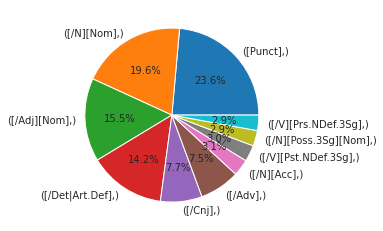

In [12]:
pos_frequencies.head(10).plot.pie(autopct="%.1f%%")  # kiválasztjuk a 10 leggyakoribb postaget majd piechartként plotoljuk
plt.ylabel('')  # eltüntetjük bal oldalt az y tengelyt
plt.show()  # szokás kiírni, hogy ne keletkezzen egyéb kimenet 

In [13]:
lemmas_freq = data['lemma'].value_counts()  # most lemmákat számolunk össze
lemmas_freq

a              13246
,              13067
.               8372
az              5142
és              3599
               ...  
gettósítás         1
termény            1
rettegett          1
fölerõsödik        1
lényegi            1
Name: lemma, Length: 21930, dtype: int64

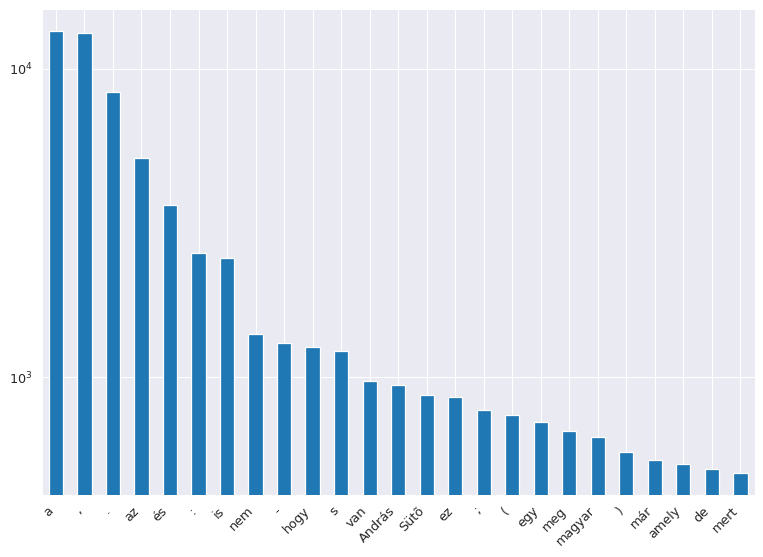

In [14]:
plt.figure(figsize=(10, 7), dpi=92)  # létrehozzuk az ábrát egy bizonyos méretben
lemmas_freq.head(25).plot.bar()  # a top 25 lemmából csinálunk barchartot
plt.yscale('log')  # logaritmikus skálát használunk, mert a nyelv Zipf-eloszlást követ
plt.xticks(rotation=45, horizontalalignment="right")  # elforgatjuk az x tengely címkéit, hogy lássuk szépen a szavak
plt.show()

## A szógyakoriságok Zipf-eloszlásának bemutatása 6 sorban

https://hu.wikipedia.org/wiki/Zipf-eloszl%C3%A1s  Zipf-törvény azt állítja, hogy egy természetes nyelv egyes részeiben egy szó előfordulási gyakorisága fordítottan arányos a gyakorisági (előfordulási) táblában levő rangjával, azaz log-log skálán egy egyenest kell látnunk.

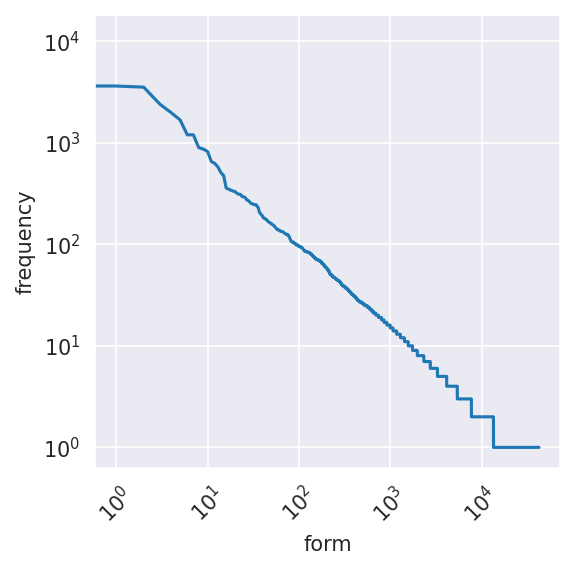

In [15]:
no_punct_freq = data.query('xpostag != "[Punct]"').value_counts('form')  # a nem írásjeleket kivesszük
plt.figure(figsize=(4,4), dpi=150)
no_punct_freq.plot.line(rot=45)  # lineplotot készítünk
plt.ylabel('frequency')  # elnevezzük az y tengelyt
plt.yscale('log')
plt.xscale('log')

# Több kimenet összefűzése
Most éppen mondatokat adunk át, de fájlokkal pontosan ugyanígy működik. Szétvágjuk az első enternél fejlécre és tartalomra a kimenetet, az első fejlécet megtartjuk, a többit meg eldobjuk. A kimenetek végén dupla enter keletkezik, azt levágjuk.

In [16]:
sentences = ['Ki korán kel, aranyat lel.', 'Száz sasszem meg száz sasszem az sok száz sasszem.', 'Jobb egy lúdnyak tíz tyúknyaknál.']
output = ''
for sentence in sentences:
    r = requests.post('http://127.0.0.1:5000/tok/morph/pos', data={'text': sentence})
    header, content = r.text.split('\n', 1)
    if output == '':
        output += header + '\n'
    output += content

A feldolgozást tovább lehet láncolni. Ha egy már POS-taggelt szöveget szeretnénk dependenciaelemezni, akkor azt egyszerűen lehet.

In [17]:
r = requests.post('http://127.0.0.1:5000/conv-morph/dep', files={'file': output}) 

In [18]:
table = pd.read_table(StringIO(r.text))

In [19]:
table[['form', 'xpostag', 'id', 'deprel', 'head']]

,form,xpostag,id,deprel,head
0,Ki,[/Prev],1,TLOCY,3
1,korán,[/Adv],2,TLOCY,3
2,kel,[/V][Prs.NDef.3Sg],3,ROOT,0
3,",",[Punct],4,PUNCT,3
4,aranyat,[/N][Acc],5,OBJ,6
5,lel,[/V][Prs.NDef.3Sg],6,COORD,3
6,.,[Punct],7,PUNCT,0
7,Száz,[/Num][Nom],1,ATT,2
8,sasszem,[/N][Nom],2,ATT,9
9,meg,[/Cnj],3,CONJ,2
